In [6]:
import numpy as np
import xarray as xr
import pandas as pd


import scipy.stats as stats
import cartopy as cart

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm
import sys

from importlib import reload
sys.path.append('/nethome/4302001/NASTMW_DIC/tools')
import preprocess_timeseries
import event_identification
# import  

%config InlineBackend.figure_format = 'retina'

In [7]:
data_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectories_postprocessed/"
ds = xr.open_dataset(data_dir + "EDW_wfluxes_B_2000-09-01_1095d_dt90_odt24.nc").isel(obs=slice(0, 366))
odt_days = int(np.diff(ds.isel(trajectory=0).time.data)[0]) / 1e9 / 60 / 60 / 24

In [8]:
mesh_z = xr.open_dataset("~/local_data/mesh/mesh_zgr_PSY4V2_deg_NA_subset.nc")
toplayer_bound = mesh_z.gdepw_1d.data[1]

In [9]:
# ds = preprocess_timeseries.preprocess(ds, fluxes=True, entry_exit=False, cumsums=False)

In [10]:
# we select 10 random trajectories for illustration
np.random.seed(42)
rantraj = np.sort(np.random.choice(np.arange(0, ds.dims['trajectory']), 10, replace=False))
colors = plt.cm.tab10(np.linspace(0, 1, 10))


In [11]:
def plot_trajectories(ds, rantraj, obsslice=slice(None, None)):
    fig = plt.figure(figsize=(5, 6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212, projection=cart.crs.PlateCarree())
    for i, traj in enumerate(rantraj):
        ax1.scatter(ds.lat.isel(trajectory=traj, obs=obsslice), -ds.z.isel(trajectory=traj, obs=obsslice), s=2, color=colors[i])
        ax1.plot(ds.lat.isel(trajectory=traj, obs=obsslice), -ds.z.isel(trajectory=traj, obs=obsslice), linewidth=0.5, color=colors[i])
        ax1.set_xlabel("Latitude (deg)")
        ax1.set_ylabel("Depth (m)")


        map = ax2.scatter(ds.lon.isel(trajectory=traj, obs=obsslice), ds.lat.isel(trajectory=traj, obs=obsslice), s=2, color=colors[i], transform=cart.crs.PlateCarree(), label=f"Trajectory {traj}")
        ax2.plot(ds.lon.isel(trajectory=traj, obs=obsslice), ds.lat.isel(trajectory=traj, obs=obsslice), linewidth=0.5, color=colors[i], transform=cart.crs.PlateCarree())

        ax2.coastlines()
        ax2.gridlines(draw_labels=['left', 'bottom'], linestyle='--', linewidth=0.5, zorder=0)

    # get the handles and labels for the first axes
    ax2.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, -0.2))
    fig.tight_layout()



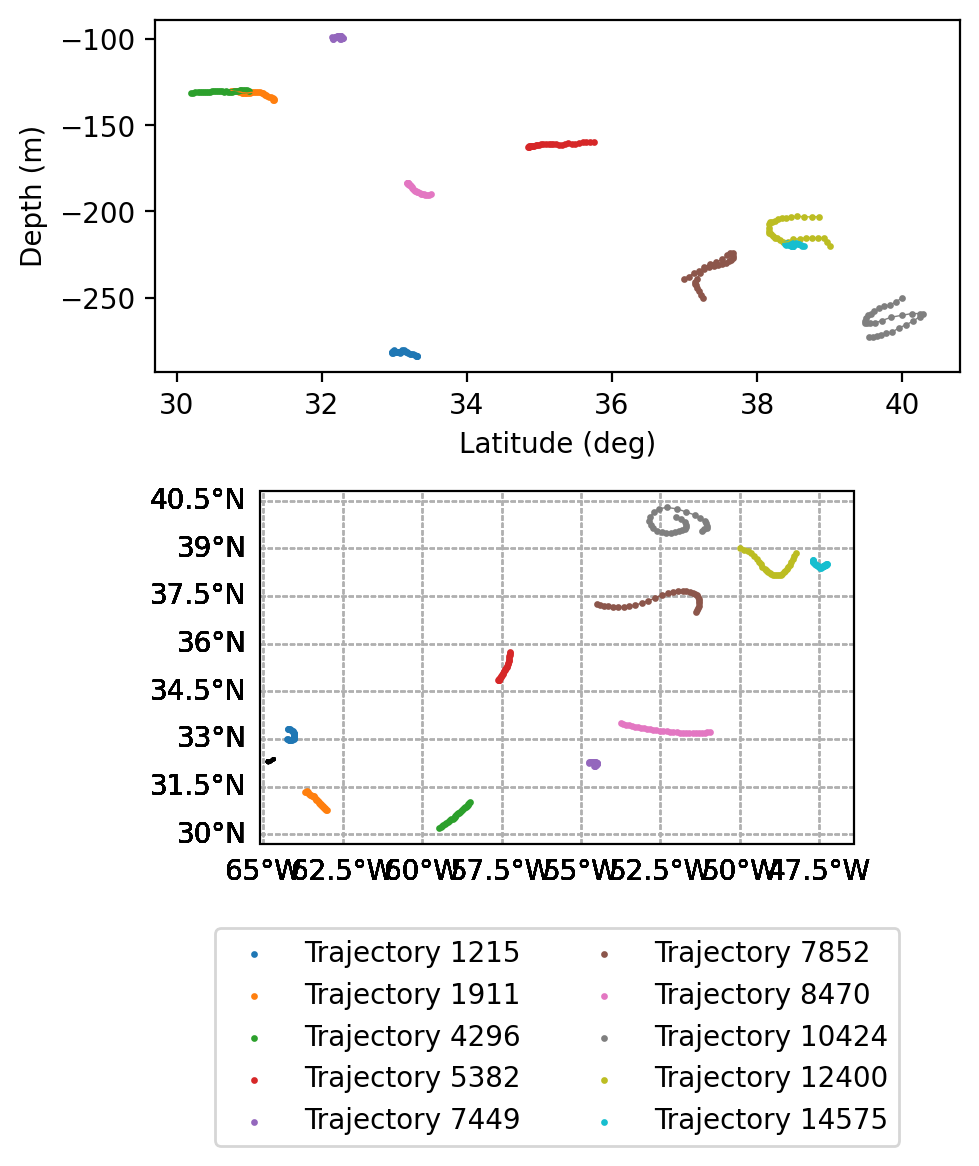

In [12]:
plot_trajectories(ds, rantraj, obsslice=slice(None, 30))

In [13]:
def plot_flux_attribution(ds, obsslice=slice(None, 30)):
    ds_sub = ds.isel(obs=obsslice)
    fig, axs = plt.subplots(3, 3, figsize=(8, 7))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC'][traj], label="total")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_bio_soft'][traj], label="soft-tissue")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_bio_carbonate'][traj], label="carbonate")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_diff'][traj], label="Mixing")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_residual'][traj], label="residual")
        
        ax.set_title(f"Traj. {traj} — avg depth = {ds_sub.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        # divide the values on the x-axis by 2
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel(r"Flux (mmol m$^{-3}$ / $\Delta$ t)")
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=5)
    fig.suptitle(rf"DIC fluxes and their attribution ($\Delta$ t = {odt_days} day))")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 

/tmp/ipykernel_20055/3640122613.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


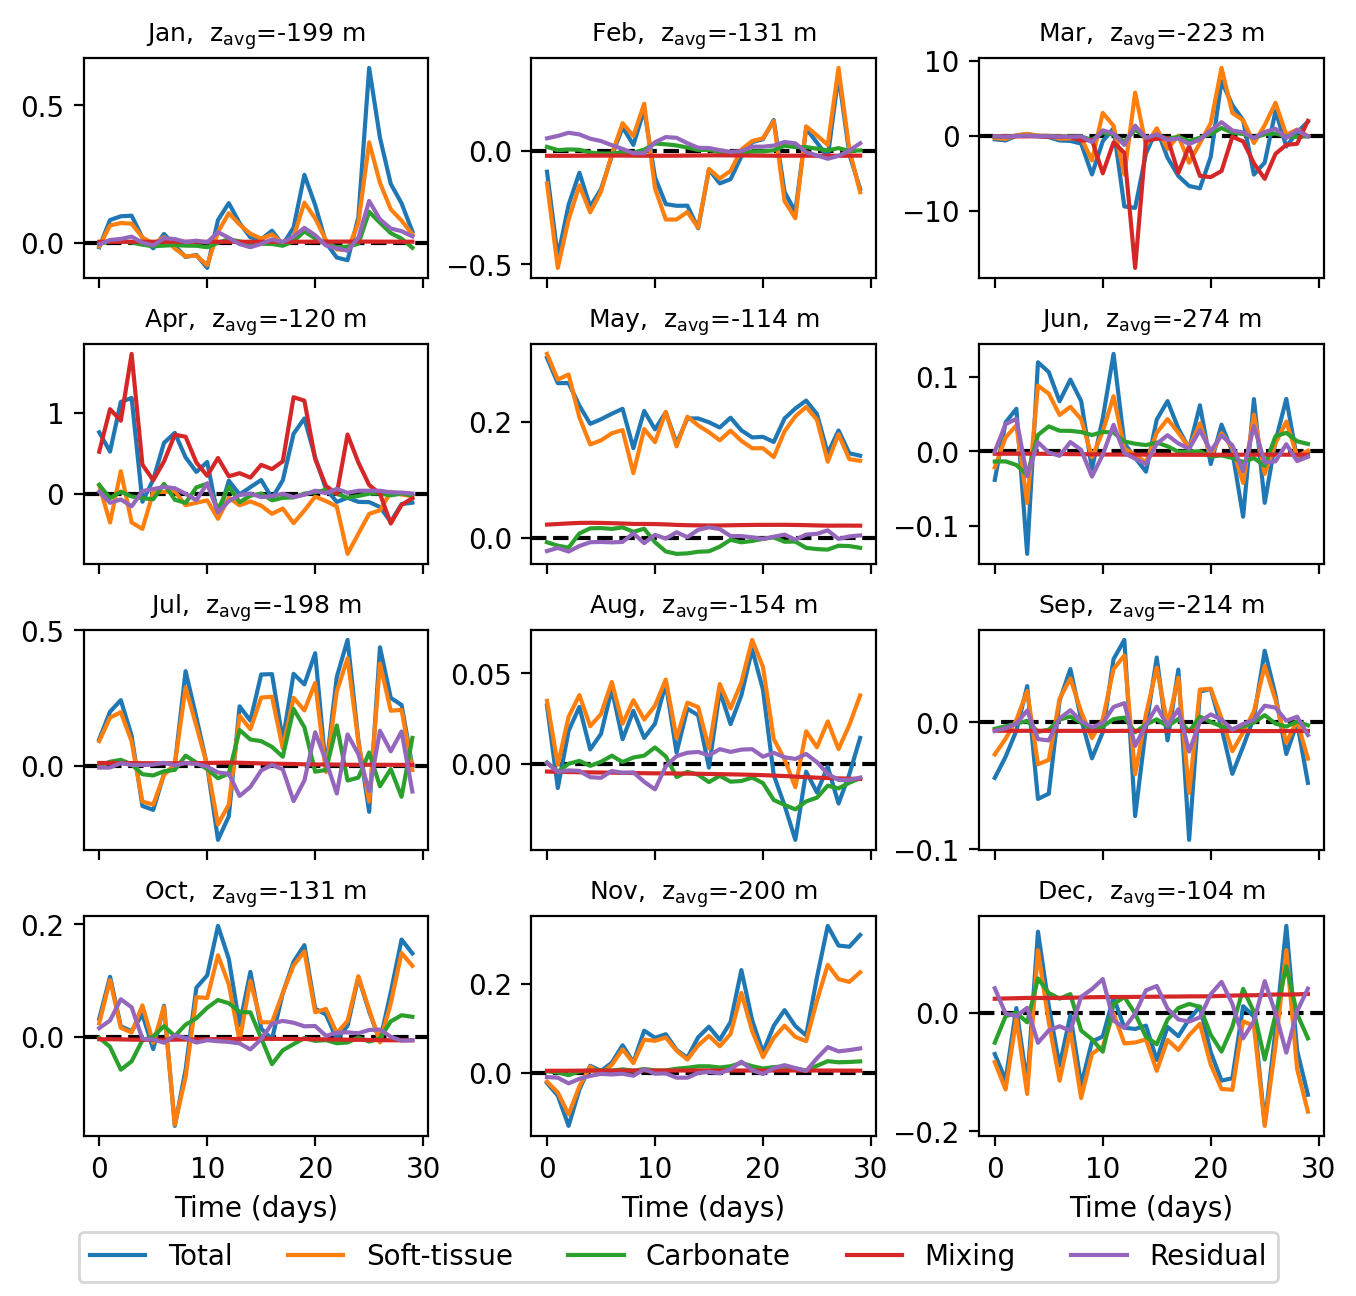

In [14]:
np.random.seed(69)

fig = plt.figure(figsize=(8, 7))
gs = fig.add_gridspec(4, 3, wspace=0.3, hspace=0.3)

first_day_of_month = [0, 31, 61, 92, 122, 153, 184, 214, 245, 275, 306, 337]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

rantraj_2 = np.sort(np.random.choice(np.arange(0, ds.dims['trajectory']), 12, replace=False))

for i, traj in enumerate(rantraj_2):
    ax = fig.add_subplot(gs[i])

    startobs = ((3*30+1) + first_day_of_month[i] ) % 365
    ds_sub = ds.isel(obs=slice(startobs, startobs+30), trajectory=traj)

    ax.plot(np.arange(0, 30), ds_sub['DDIC'], label="Total")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_bio_soft'], label="Soft-tissue")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_bio_carbonate'], label="Carbonate")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_diff'], label="Mixing")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_residual'], label="Residual")
    
    # ax.set_title(f"Traj. {traj} — avg depth = {ds_sub.z.mean().values:.0f} m", color=colors[i], fontsize=10)
    # divide the values on the x-axis by 2
    
    if i < 9:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (days)")
    ax.axhline(0, color="k", linestyle="--", zorder=0)

    ax.set_title(f"{months[i]},  "+r"z$_\text{avg}$="+ f"-{ds_sub.z.mean().values:.0f} m", fontsize=9)
    

fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=5)
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
plt.savefig("figures/example_fluxes_monthly.pdf", dpi=300)

In [15]:
def plot_stoichiometry_total(ds, obsslice=slice(None, 30)):
    # Plot the fluxes of nitrate and phosphate
    ds = ds.isel(obs=obsslice)
    y_min = np.min([ds['DNO3'][rantraj].min(), (16*ds['DPO4'][rantraj]).min()])
    y_max = np.max([ds['DNO3'][rantraj].max(), (16*ds['DPO4'][rantraj]).max()])

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DNO3'][traj], label="NO3")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4'][traj], label="PO4")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4'][traj] * 16, linestyle='--', label="NO3 from stoichiometry")
        ax.set_title(f"Traj {traj} — avg depth = {ds.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel(r"Flux (mmol m$^{-3}$ / $\Delta$ t")

        ax.set_ylim(y_min, y_max)
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=3)

    fig.suptitle("Nitrate and phosphate fluxes (total)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 

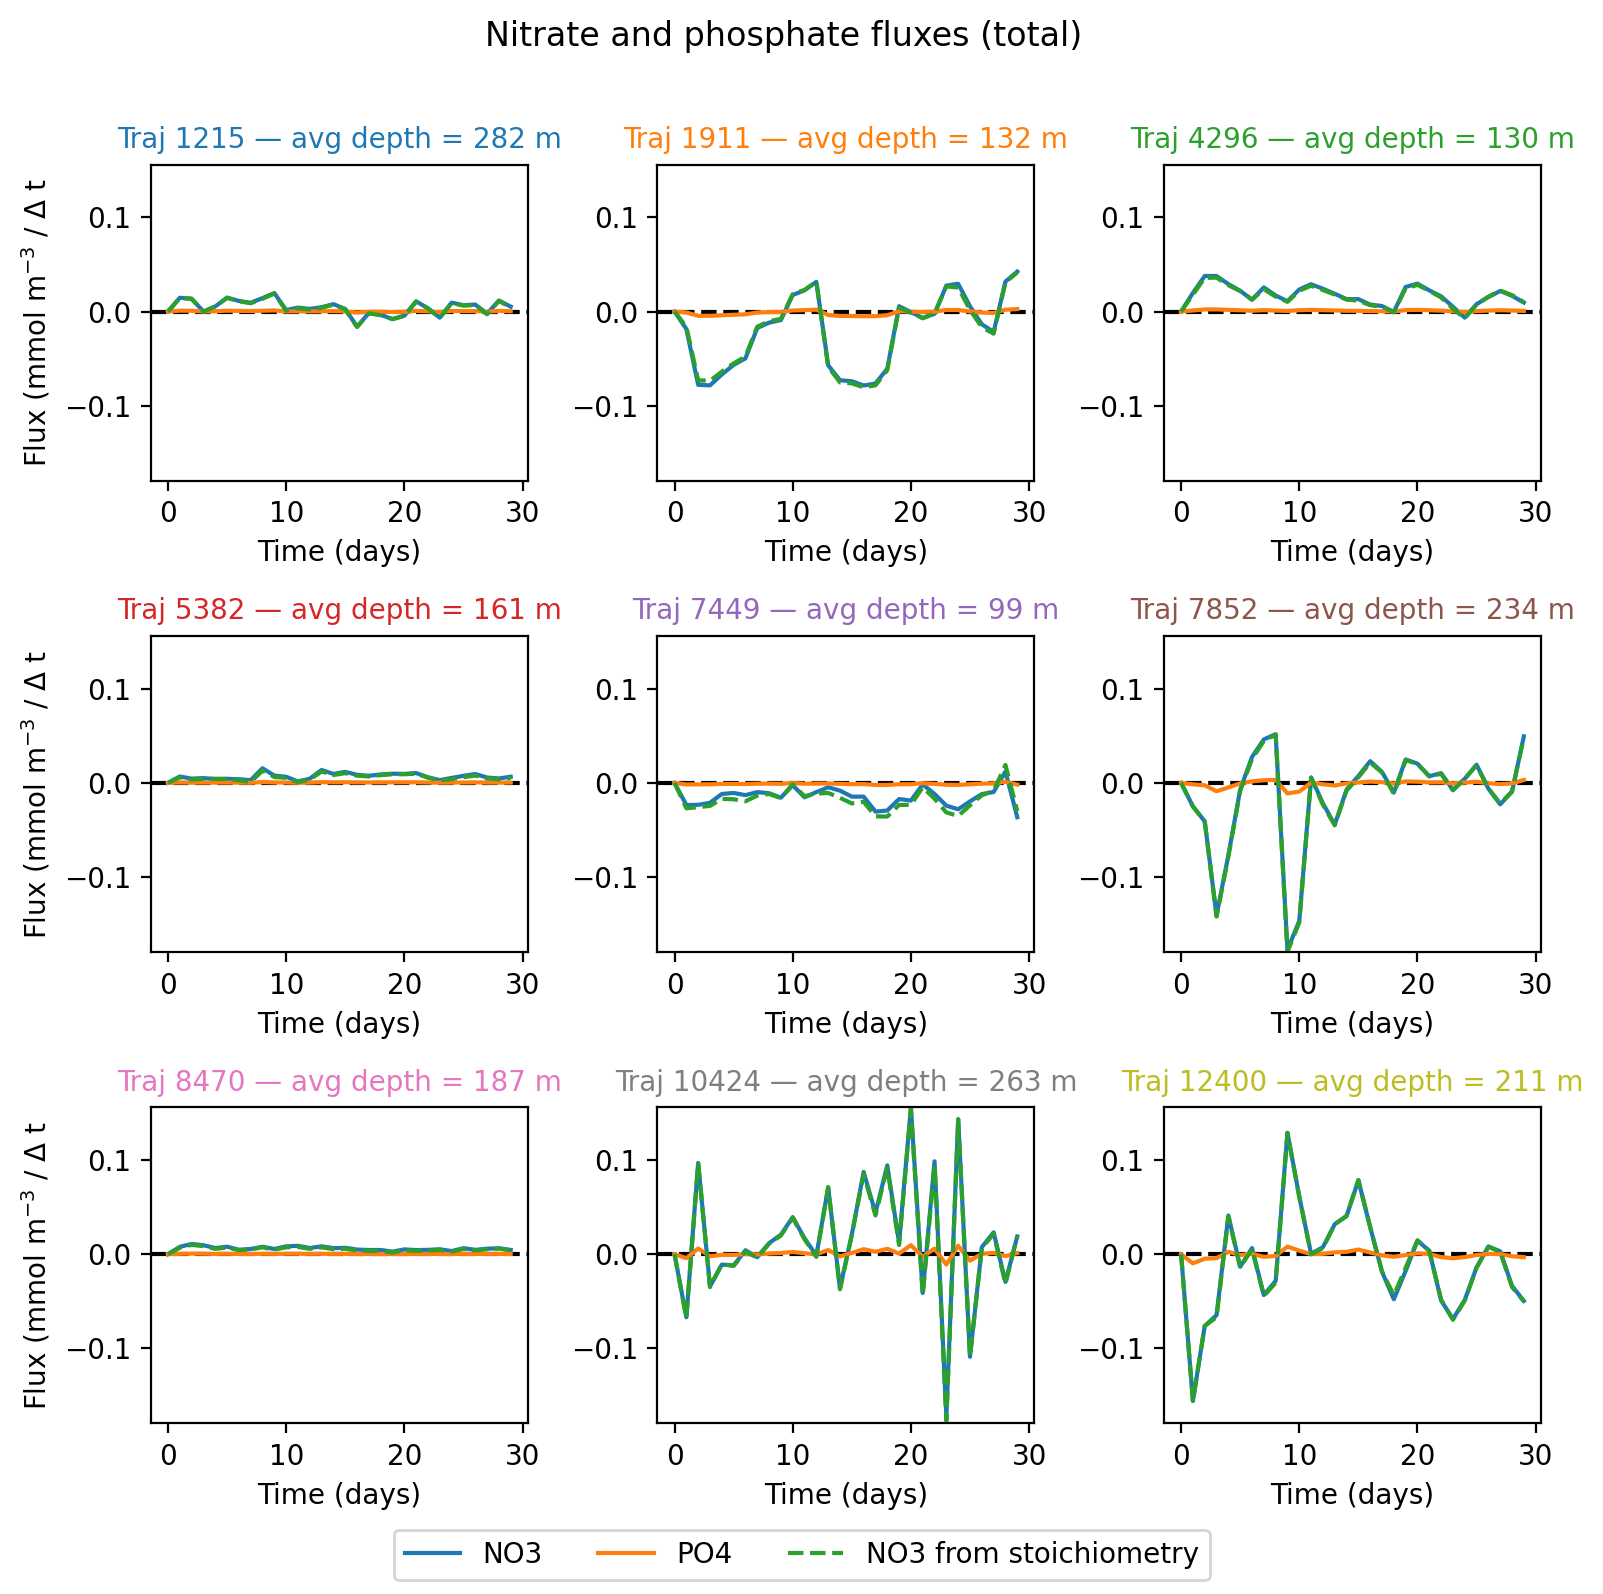

In [16]:
plot_stoichiometry_total(ds)

In [17]:
def plot_stoichiometry_bio(ds, obsslice=slice(None, 30)):
    # Plot the biogeochemical fluxes of nitrate and phosphate
    ds = ds.isel(obs=obsslice)
    
    y_min = np.min([ds['DNO3_bio'][rantraj].min(), (16*ds['DPO4_bio'][rantraj]).min()])
    y_max = np.max([ds['DNO3_bio'][rantraj].max(), (16*ds['DPO4_bio'][rantraj]).max()])

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DNO3_bio'][traj], label="DNO3")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4_bio'][traj], label="DPO4")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4_bio'][traj] * 16, linestyle='--', label="DNO3 from stoichiometry")
        ax.set_title(f"Traj {traj} — avg depth = {ds.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel("Flux (mmol m$^{-3}$ / $\Delta$ t")
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=3)
    fig.suptitle("Nitrate and phosphate fluxes (biogeochemistry-attributed)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 



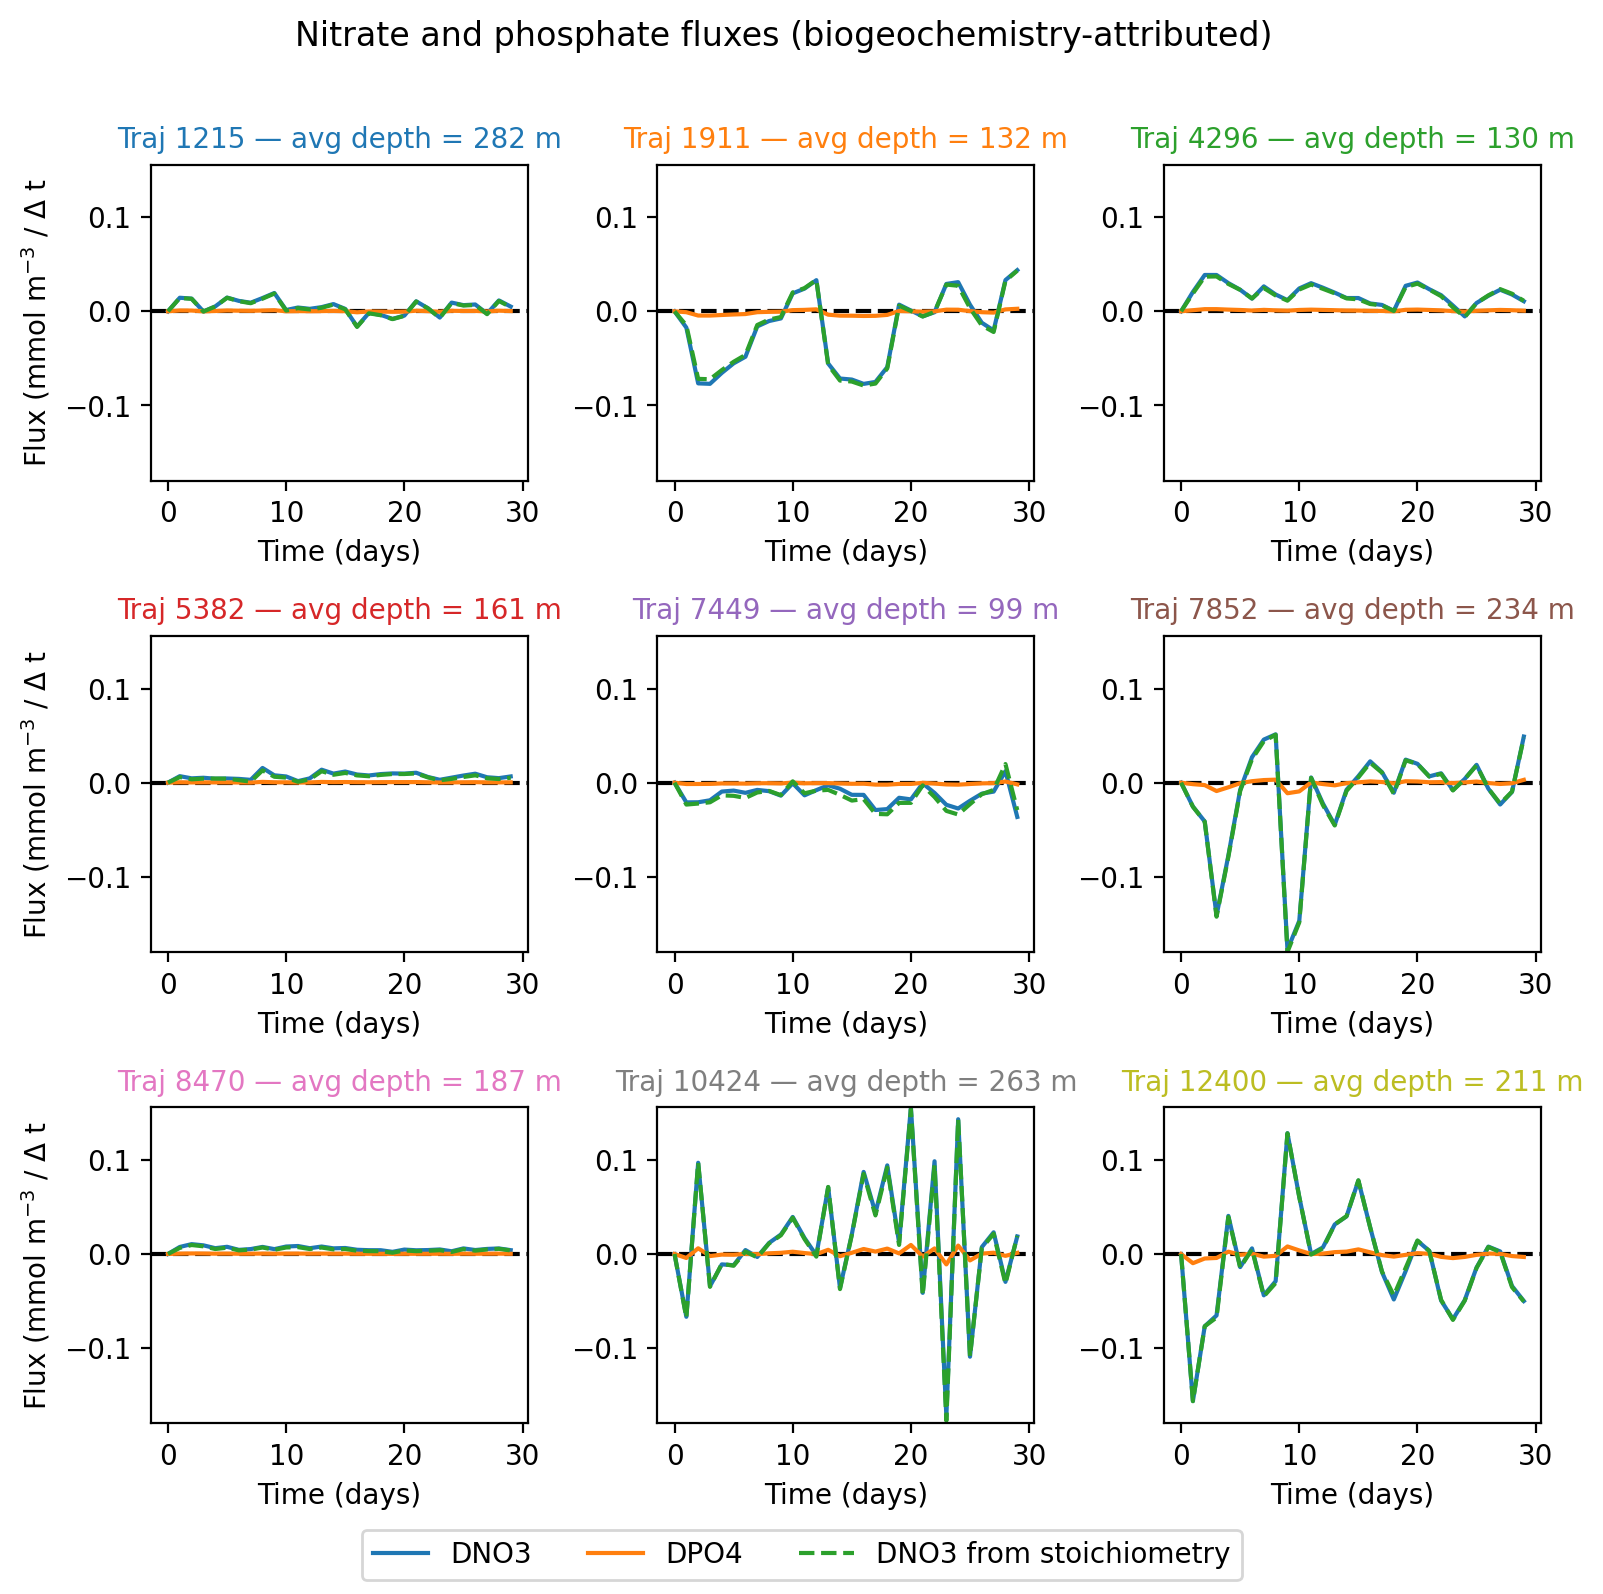

In [18]:
plot_stoichiometry_bio(ds)

In [19]:
def compute_percentages(ds):
    percentages_residual = ds['DDIC_residual'] / ds['DDIC'] * 100
    percentages_bio = ds['DDIC_bio'] / ds['DDIC'] * 100
    percentages_bio_soft = ds['DDIC_bio_soft'] / ds['DDIC'] * 100
    percentages_bio_carbonate = ds['DDIC_bio_carbonate'] / ds['DDIC'] * 100
    percentages_Mixing = ds['DDIC_diff'] / ds['DDIC'] * 100

    df = pd.DataFrame({
        "Soft-tissue": percentages_bio_soft.isel(trajectory=rantraj, obs=slice(1,21)).mean('obs'),
        "Carbonate": percentages_bio_carbonate.isel(trajectory=rantraj, obs=slice(1,21)).mean('obs'),
        "Mixing": percentages_Mixing.isel(trajectory=rantraj, obs=slice(1,21)).mean('obs'),
        "Residual": percentages_residual.isel(trajectory=rantraj, obs=slice(1,21)).mean('obs'),
    }, index=[f"Trajectory {traj}" for traj in rantraj])

    return df

In [20]:
df = compute_percentages(ds)


In [21]:
df

,Soft-tissue,Carbonate,Mixing,Residual
Trajectory 1215,66.859856,37.495892,3.384728,-7.740472
Trajectory 1911,120.193275,-2.749683,-13.073690,-4.369914
Trajectory 4296,138.704849,0.204924,-10.555642,-28.354122
Trajectory 5382,-559.303040,278.352478,10.835843,370.114716
Trajectory 7449,70.954575,7.524610,19.546793,1.974018
Trajectory 7852,26.206106,40.108833,-3.761028,37.446087
Trajectory 8470,101.479149,11.556601,12.310716,-25.346462
Trajectory 10424,86.113365,1.503909,0.109649,12.273074
Trajectory 12400,71.691315,4.585924,0.138996,23.583767
Trajectory 14575,78.268150,2.771277,-0.380327,19.340897


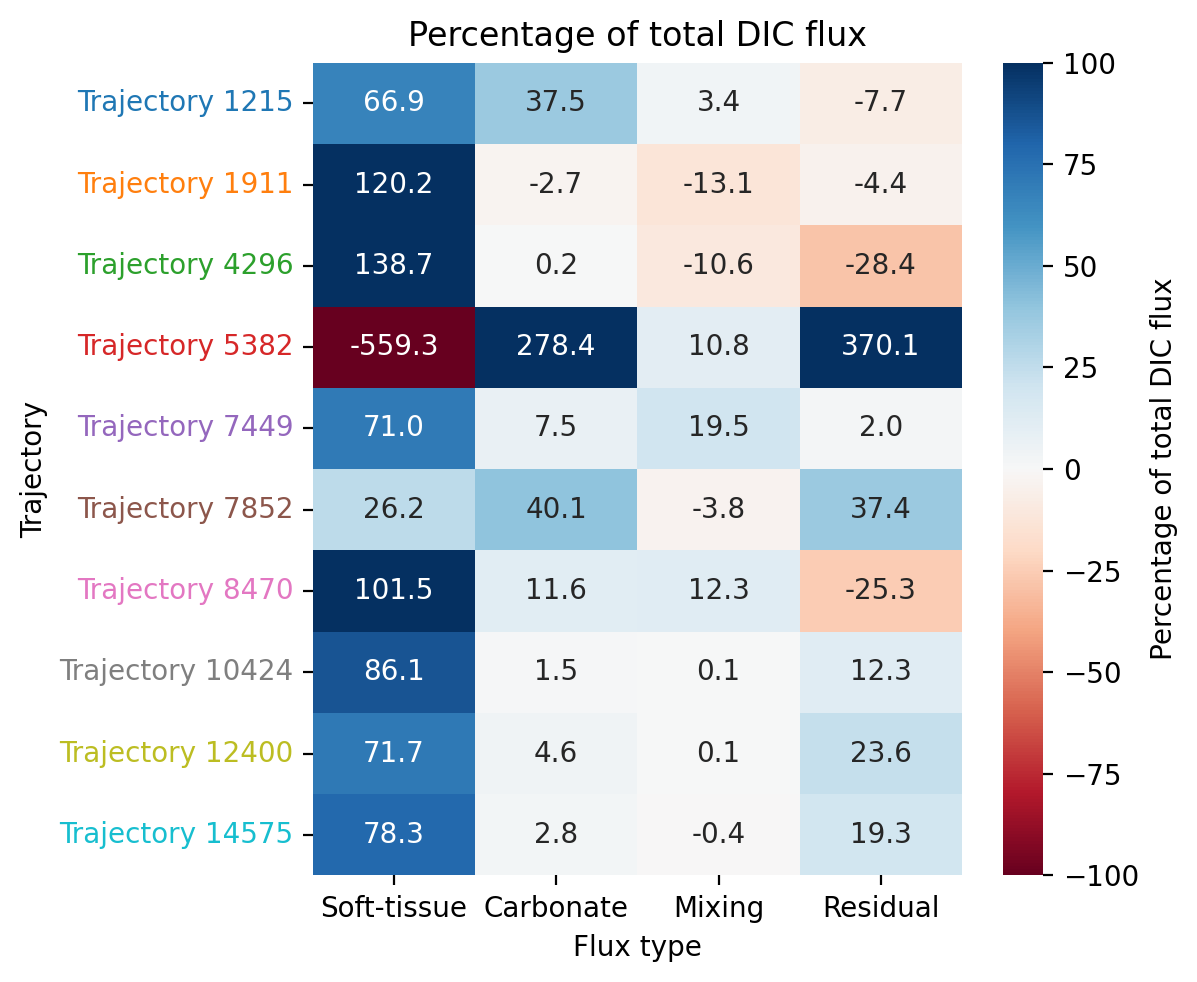

In [22]:
# plot the dataframe as a heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(df, annot=True, cmap="RdBu", vmin=-100, vmax=100, ax=ax, fmt=".1f", cbar_kws={"label": "Percentage of total DIC flux"})
ax.set_title("Percentage of total DIC flux")
ax.set_xlabel("Flux type")
ax.set_ylabel("Trajectory")

for i, traj in enumerate(rantraj):
    ax.get_yticklabels()[i].set_color(colors[i])

fig.tight_layout()

In [23]:
# slicing in order to match up the `obs` dimension with the fluxes
below_mixing = ds.z.isel(obs=slice(1, None)) > ds.MLDturb.isel(obs=slice(1, None))
below_mixed = ds.z.isel(obs=slice(1, None)) > ds.MLDtemp.isel(obs=slice(1, None))
below_200 = ds.z.isel(obs=slice(1, None)) > 200
uppermask = ds.z.isel(obs=slice(1, None)) < xr.open_dataset("/nethome/4302001/local_data/mesh/mesh_zgr_PSY4V2_deg_NA_subset.nc").gdepw_1d.data[1]

# Investigating DIC flux Contributions

In [24]:
from scipy.stats import lognorm, kstest, skewnorm, skew

In [25]:
abs_flux_strength_residual  = np.abs(ds['DDIC_residual']).isel(obs=slice(1, None))
abs_flux_strength_bio = np.abs(ds['DDIC_bio']).isel(obs=slice(1, None))
abs_flux_strength_bio_soft = np.abs(ds['DDIC_bio_soft']).isel(obs=slice(1, None))
abs_flux_strength_bio_carbonate = np.abs(ds['DDIC_bio_carbonate']).isel(obs=slice(1, None))
abs_flux_strength_Mixing = np.abs(ds['DDIC_diff']).isel(obs=slice(1, None))

total_abs_strength = abs_flux_strength_residual + abs_flux_strength_bio + abs_flux_strength_Mixing
total_abs_strength.max()

<xarray.DataArray ()>
array(71.37310791)

In [26]:
pos_flux_strength_residual = ds['DDIC_residual'].isel(obs=slice(1, None)).where(ds['DDIC_residual'].isel(obs=slice(1, None)) > 0)
pos_flux_strength_bio = ds['DDIC_bio'].isel(obs=slice(1, None)).where(ds['DDIC_bio'].isel(obs=slice(1, None)) > 0)
pos_flux_strength_bio_soft = ds['DDIC_bio_soft'].isel(obs=slice(1, None)).where(ds['DDIC_bio_soft'].isel(obs=slice(1, None)) > 0)
pos_flux_strength_bio_carbonate = ds['DDIC_bio_carbonate'].isel(obs=slice(1, None)).where(ds['DDIC_bio_carbonate'].isel(obs=slice(1, None)) > 0)
pos_flux_strength_Mixing = ds['DDIC_diff'].isel(obs=slice(1, None)).where(ds['DDIC_diff'].isel(obs=slice(1, None)) > 0)
pos_flux_total = ds['DDIC'].isel(obs=slice(1, None)).where(ds['DDIC'].isel(obs=slice(1, None)) > 0)

neg_flux_strength_residual = ds['DDIC_residual'].isel(obs=slice(1, None)).where(ds['DDIC_residual'].isel(obs=slice(1, None)) < 0)
neg_flux_strength_bio = ds['DDIC_bio'].isel(obs=slice(1, None)).where(ds['DDIC_bio'].isel(obs=slice(1, None)) < 0)
neg_flux_strength_bio_soft = ds['DDIC_bio_soft'].isel(obs=slice(1, None)).where(ds['DDIC_bio_soft'].isel(obs=slice(1, None)) < 0)
neg_flux_strength_bio_carbonate = ds['DDIC_bio_carbonate'].isel(obs=slice(1, None)).where(ds['DDIC_bio_carbonate'].isel(obs=slice(1, None)) < 0)
neg_flux_strength_Mixing = ds['DDIC_diff'].isel(obs=slice(1, None)).where(ds['DDIC_diff'].isel(obs=slice(1, None)) < 0)
neg_flux_total = ds['DDIC'].isel(obs=slice(1, None)).where(ds['DDIC'].isel(obs=slice(1, None)) < 0)

In [27]:
fluxes = {"pos_residual" :  pos_flux_strength_residual, 
          "pos_bio" : pos_flux_strength_bio,
          "pos_bio_soft" : pos_flux_strength_bio_soft,
          "pos_bio_carbonate" : pos_flux_strength_bio_carbonate,
          "pos_diff" : pos_flux_strength_Mixing,
          "pos_total" : pos_flux_total,
          "neg_residual" :  -neg_flux_strength_residual,
          "neg_bio" : -neg_flux_strength_bio,
          "neg_bio_soft" : -neg_flux_strength_bio_soft,
          "neg_bio_carbonate" : -neg_flux_strength_bio_carbonate,
          "neg_diff" : -neg_flux_strength_Mixing,
          "neg_total" : -neg_flux_total,
          "abs_total" : total_abs_strength, 
          "abs_residual" : abs_flux_strength_residual,
          "abs_bio" : abs_flux_strength_bio,
          "abs_bio_soft" : abs_flux_strength_bio_soft,
          "abs_bio_carbonate" : abs_flux_strength_bio_carbonate,
          "abs_diff" : abs_flux_strength_Mixing}
           

In [28]:
def xargmax(da):
    return np.unravel_index(np.argmax(da.values), da.shape)
xargmax(total_abs_strength)

(7900, 114)

In [29]:
def compute_params(da, nanmask=True):
    da_flat = da.values.flatten()
    if nanmask:
        da_flat = da_flat[~np.isnan(da_flat)]
    params_lognorm = lognorm.fit(da_flat)
    params_skewnorm = skewnorm.fit(np.log10(da_flat))

    return params_lognorm, params_skewnorm

In [30]:
param_dict = pickle.load(open("stores/flux_params.json", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'stores/flux_params.json'

# Investigating Relative Contributions to ΔDIC

In [31]:
def compute_relabs(ds):
    abs_flux_strength_residual  = np.abs(ds['DDIC_residual'])
    abs_flux_strength_bio = np.abs(ds['DDIC_bio'])
    abs_flux_strength_bio_soft = np.abs(ds['DDIC_bio_soft'])
    abs_flux_strength_bio_carbonate = np.abs(ds['DDIC_bio_carbonate'])
    abs_flux_strength_Mixing = np.abs(ds['DDIC_diff'])

    total_abs_strength = abs_flux_strength_residual + abs_flux_strength_bio_soft + abs_flux_strength_bio_carbonate + abs_flux_strength_Mixing
    percentage_abs_residual = abs_flux_strength_residual / total_abs_strength * 100
    percentage_abs_bio = abs_flux_strength_bio / total_abs_strength * 100
    percentage_abs_bio_soft = abs_flux_strength_bio_soft / total_abs_strength * 100
    percentage_abs_bio_carbonate = abs_flux_strength_bio_carbonate / total_abs_strength * 100
    percentage_abs_Mixing = abs_flux_strength_Mixing / total_abs_strength * 100


    df_relabs = pd.DataFrame({
        "Biogeochemical": percentage_abs_bio.isel(trajectory=rantraj, obs=slice(1,None)).mean('obs'),
        "Soft-tissue": percentage_abs_bio_soft.isel(trajectory=rantraj, obs=slice(1,None)).mean('obs'),
        "Carbonate": percentage_abs_bio_carbonate.isel(trajectory=rantraj, obs=slice(1,None)).mean('obs'),
        "Mixing": percentage_abs_Mixing.isel(trajectory=rantraj, obs=slice(1,None)).mean('obs'),
        "Residual": percentage_abs_residual.isel(trajectory=rantraj, obs=slice(1,None)).mean('obs'),
    }, index=[f"Trajectory {traj}" for traj in rantraj])

    df_relabs.loc["Avg. of above"] = df_relabs.mean()

    df_relabs.loc["Avg. of all"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).mean()),

    })

    df_relabs.loc["Avg. of all below mixed"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_mixed).mean()),
    })

    df_relabs.loc["Avg. of all below mixing"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_mixing).mean()),

    })

    df_relabs.loc["Avg. of all in mixed"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),

    })

    df_relabs.loc["Avg. of all in mixing"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),

    })

    df_relabs.loc["Avg. of all < 200m"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_200).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_200).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_200).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_200).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_200).mean()),

    })


    return df_relabs

In [32]:
def cumsum_maximum_accounts_for(da, percentage):
    """
    Computes minimum value, for which if the array is filtered to contain
    only values larger than this value, the cumulative sum of the array
    accounts for at least the given percentage of the total sum of the array.
    This usually gives a higher value than the percentile, because the
    higher values in the array contribute more to the cumulative sum.

    Parameters
    ----------
    da : xarray.DataArray or np.array
        Input array
    percentage : float
        Percentage of the total sum of the array that should be accounted for.
        Should be between 0 and 1.
    """
    assert percentage >= 0 and percentage <= 1, "Percentage must be between 0 and 1"
    if type(da) == xr.DataArray:
        da = da.values
    arr = da.flatten()
    arr = arr[~np.isnan(arr)]
    arr_sorted = np.sort(arr)[::-1]
    cumsum = np.cumsum(arr_sorted)
    cumdist = cumsum / np.sum(arr_sorted)
    index = np.argmax(cumdist >= percentage)
    minval = arr_sorted[index]

    return minval

In [33]:
def compute_relabs_significant(ds, percentage=None):
    """
    Compute the relative contribution of the different processes to the total flux strength.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the trajectories
    percentage : int, optional
        Only select the fluxes that together account for this percentage of the total DIC change.
    np.percentile(total_abs_strength, 5)
    """

    abs_flux_strength_residual = np.abs(ds['DDIC_residual'])
    abs_flux_strength_bio = np.abs(ds['DDIC_bio'])
    abs_flux_strength_bio_soft = np.abs(ds['DDIC_bio_soft'])
    abs_flux_strength_bio_carbonate = np.abs(ds['DDIC_bio_carbonate'])
    abs_flux_strength_Mixing = np.abs(ds['DDIC_diff'])

    total_abs_strength = abs_flux_strength_residual + abs_flux_strength_bio_soft + abs_flux_strength_bio_carbonate + abs_flux_strength_Mixing

    percentage_abs_residual = abs_flux_strength_residual / total_abs_strength * 100
    percentage_abs_bio = abs_flux_strength_bio / total_abs_strength * 100
    percentage_abs_bio_soft = abs_flux_strength_bio_soft / total_abs_strength * 100
    percentage_abs_bio_carbonate = abs_flux_strength_bio_carbonate / total_abs_strength * 100
    percentage_abs_Mixing = abs_flux_strength_Mixing / total_abs_strength * 100

    df_relabs = pd.DataFrame(columns=["Biogeochemical", "Soft-tissue", "Carbonate", "Mixing", "Residual"])

    percentile_value = cumsum_maximum_accounts_for(total_abs_strength, percentage)
    percentile_mask = total_abs_strength > percentile_value

    percentile_value_below_mixed = cumsum_maximum_accounts_for(total_abs_strength.where(below_mixed), percentage)
    percentile_mask_below_mixed = total_abs_strength > percentile_value_below_mixed

    percentile_value_below_mixing = cumsum_maximum_accounts_for(total_abs_strength.where(below_mixing), percentage)
    percentile_mask_below_mixing = total_abs_strength > percentile_value_below_mixing

    percentile_value_in_mixed = cumsum_maximum_accounts_for(total_abs_strength.where(~below_mixed * ~uppermask), percentage)
    percentile_mask_in_mixed = total_abs_strength > percentile_value_in_mixed

    percentile_value_in_mixing = cumsum_maximum_accounts_for(total_abs_strength.where(~below_mixing * ~uppermask), percentage)
    percentile_mask_in_mixing = total_abs_strength > percentile_value_in_mixing

    percentile_value_below_200 = cumsum_maximum_accounts_for(total_abs_strength.where(below_200), percentage)
    percentile_mask_below_200 = total_abs_strength > percentile_value_below_200

    df_relabs.loc["Avg. of all"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(percentile_mask).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(percentile_mask).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(percentile_mask).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(percentile_mask).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(percentile_mask).mean()),

    })

    df_relabs.loc["Avg. of all below mixed"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_mixed + percentile_mask_below_mixed).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_mixed + percentile_mask_below_mixed).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_mixed + percentile_mask_below_mixed).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_mixed + percentile_mask_below_mixed).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_mixed + percentile_mask_below_mixed).mean()),

    })

    df_relabs.loc["Avg. of all below mixing"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_mixing + percentile_mask_below_mixing).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_mixing + percentile_mask_below_mixing).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_mixing + percentile_mask_below_mixing).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_mixing + percentile_mask_below_mixing).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_mixing + percentile_mask_below_mixing).mean()),

    })

    df_relabs.loc["Avg. of all in mixed"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask + percentile_mask_in_mixed).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask + percentile_mask_in_mixed).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask + percentile_mask_in_mixed).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask + percentile_mask_in_mixed).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask + percentile_mask_in_mixed).mean()),

    })

    df_relabs.loc["Avg. of all in mixing"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask + percentile_mask_in_mixing).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask + percentile_mask_in_mixing).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask + percentile_mask_in_mixing).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask + percentile_mask_in_mixing).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask + percentile_mask_in_mixing).mean()),

    })

    df_relabs.loc["Avg. of all < 200m"] = pd.Series({
        "Biogeochemical": float(percentage_abs_bio.isel(obs=slice(1, None)).where(below_200 + percentile_mask_below_200).mean()),
        "Soft-tissue": float(percentage_abs_bio_soft.isel(obs=slice(1, None)).where(below_200 + percentile_mask_below_200).mean()),
        "Carbonate": float(percentage_abs_bio_carbonate.isel(obs=slice(1, None)).where(below_200 + percentile_mask_below_200).mean()),
        "Mixing": float(percentage_abs_Mixing.isel(obs=slice(1, None)).where(below_200 + percentile_mask_below_200).mean()),
        "Residual": float(percentage_abs_residual.isel(obs=slice(1, None)).where(below_200 + percentile_mask_below_200).mean()),

    })

    return df_relabs

In [34]:
df_relabs = compute_relabs(ds)

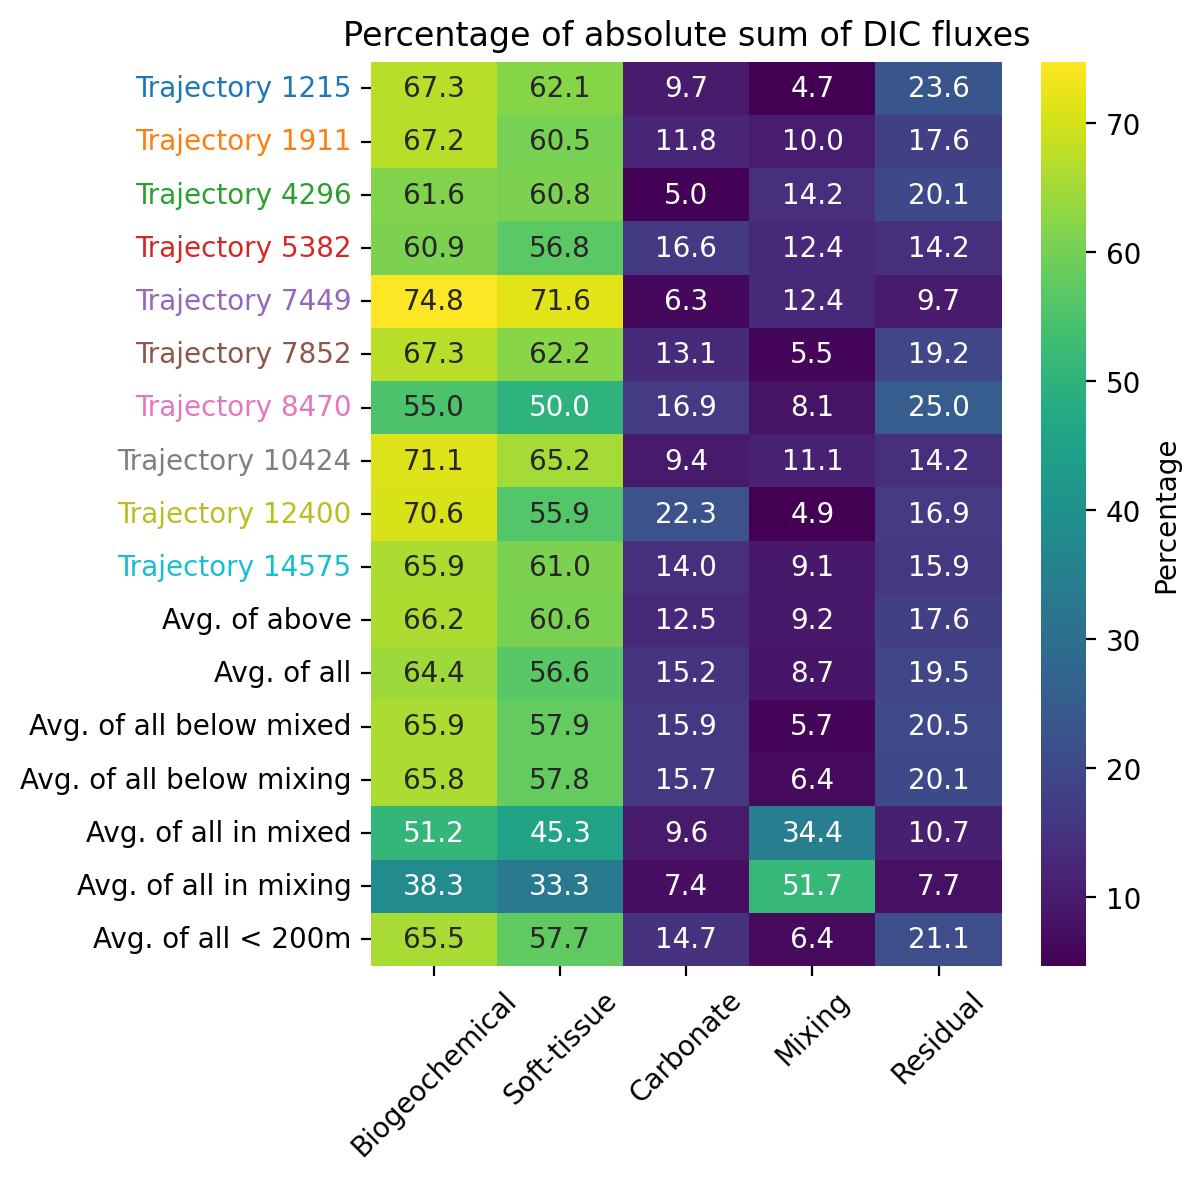

In [35]:
# plot the dataframe as a heatmap
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_relabs, annot=True, cmap="viridis", ax=ax, fmt=".1f", cbar_kws={"label": "Percentage"})
ax.set_title("Percentage of absolute sum of DIC fluxes")

for i, traj in enumerate(rantraj):
    ax.get_yticklabels()[i].set_color(colors[i])
plt.xticks(np.arange(0.5, 5+.5), df_relabs.columns, rotation=45)
fig.tight_layout()

In [36]:
df_relabs_significant = compute_relabs_significant(ds, 0.95)

In [37]:
df_relabs_significant_pretty = df_relabs_significant.rename(index={"Avg. of all": "All", "Avg. of all below mixed": "Below mixed layer", "Avg. of all below mixing": "Below mixing layer", "Avg. of all in mixed": "Within mixed layer", "Avg. of all in mixing": "Within mixing layer", "Avg. of all < 200m": "Below 200m"})

In [38]:
df_relabs_significant_pretty

,Biogeochemical,Soft-tissue,Carbonate,Mixing,Residual
All,68.011459,59.189709,14.633503,8.737823,17.438995
Below mixed layer,64.463051,56.623837,15.238794,8.691640,19.445728
Below mixing layer,64.417740,56.586494,15.246141,8.711701,19.455696
Within mixed layer,64.396698,55.271160,13.700869,16.110329,14.917595
Within mixing layer,60.701305,51.343712,12.881107,22.616232,13.158957
Below 200m,65.950302,57.566971,15.202015,8.125393,19.105595


In [39]:
from importlib import reload
reload(sns)

<module 'seaborn' from '/nethome/4302001/miniconda3/lib/python3.9/site-packages/seaborn/__init__.py'>

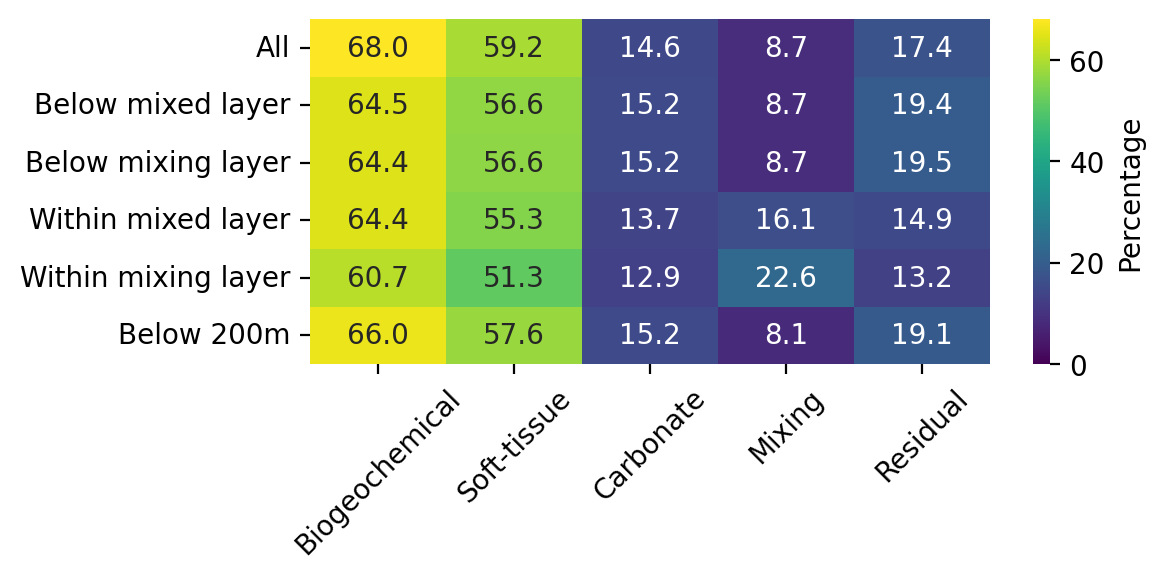

In [40]:
# plot the dataframe as a heatmap
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(df_relabs_significant_pretty, annot=True, cmap="viridis", ax=ax, fmt=".1f", cbar_kws={"label": "Percentage"}, vmin=0)
# ax.set_title("Percentage of absolute sum of DIC fluxes"+"\n" +"(fluxes that account for 95% of total DIC)")

plt.xticks(np.arange(0.5, 5+.5), df_relabs_significant_pretty.columns, rotation=45)
fig.tight_layout()
plt.savefig("figures/relative_contribution_per_process.pdf", dpi=300)

In [41]:
def compute_abs_flux(ds):
    df_abs = pd.DataFrame({
        "Biogeochemical": ds.DDIC_bio.isel(trajectory=rantraj, obs=slice(1, None)).mean('obs'),
        "Soft-tissue": ds.DDIC_bio_soft.isel(trajectory=rantraj, obs=slice(1, None)).mean('obs'),
        "Carbonate": ds.DDIC_bio_carbonate.isel(trajectory=rantraj, obs=slice(1, None)).mean('obs'),
        "Mixing": ds.DDIC_diff.isel(trajectory=rantraj, obs=slice(1, None)).mean('obs') * odt_days,
        "Residual": ds.DDIC_residual.isel(trajectory=rantraj, obs=slice(1, None)).mean('obs'),

    }, index=[f"Trajectory {traj}" for traj in rantraj])

    df_abs.loc["Avg. of above"] = df_abs.mean()

    df_abs.loc["Avg. of all"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).mean()),

    })

    df_abs.loc["Avg. of all below mixed"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).where(below_mixed).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).where(below_mixed).mean()),

    })

    df_abs.loc["Avg. of all below mixing"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).where(below_mixing).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).where(below_mixing).mean()),

    })

    df_abs.loc["Avg. of all within mixed"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).where(~below_mixed * ~uppermask).mean()),

    })

    df_abs.loc["Avg. of all within mixing"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).where(~below_mixing * ~uppermask).mean()),

    })

    df_abs.loc["Avg. of all below 200m"] = pd.Series({
        "Biogeochemical": float(ds.DDIC_bio.isel(obs=slice(1, None)).where(below_200).mean()),
        "Soft-tissue": float(ds.DDIC_bio_soft.isel(obs=slice(1, None)).where(below_200).mean()),
        "Carbonate": float(ds.DDIC_bio_carbonate.isel(obs=slice(1, None)).where(below_200).mean()),
        "Mixing": float(ds.DDIC_diff.isel(obs=slice(1, None)).where(below_200).mean()),
        "Residual": float(ds.DDIC_residual.isel(obs=slice(1, None)).where(below_200).mean()),

    })

    return df_abs

In [42]:
df_abs = compute_abs_flux(ds)

In [43]:
df_error_mean_fluxes = df_abs.iloc[-6:None].rename(index={"Avg. of all": "All", "Avg. of all below mixed": "Below mixed", "Avg. of all below mixing": "Below mixing", "Avg. of all within mixed": "Within mixed", "Avg. of all within mixing": "Within mixing", "Avg. of all below 200m": "Below 200m"})

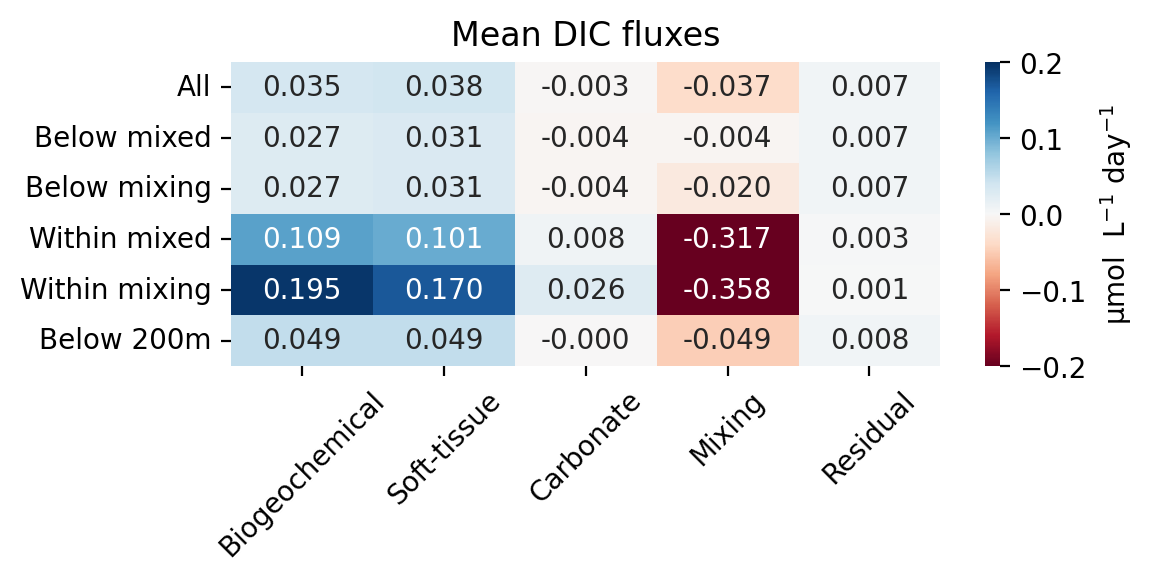

In [44]:
# plot the dataframe as a heatmap
fig, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(df_error_mean_fluxes, annot=True, cmap="RdBu", ax=ax, fmt=".3f", cbar_kws={"label": r"µmol  L$^{-1}$ day$^{-1}$"}, vmin=-0.2, vmax=0.2)
ax.set_title("Mean DIC fluxes")

# for i, traj in enumerate(rantraj):
#     ax.get_yticklabels()[i].set_color(colors[i])
plt.xticks(np.arange(0.5, 5+.5), df_relabs.columns, rotation=45)
fig.tight_layout()
plt.savefig("figures/mean_fluxes.pdf", dpi=300)

# Compute correlation between the errors

In [45]:
def plot_correlation_matrix(df, add_title=None):
    # define a function to get the p-value and asterisks for each correlation coefficient
    def get_pvalue_asterisks(x, y):
        r, p = stats.pearsonr(x, y)
        if p < 0.05:
            return f"{r:.2f}*", p
        else:
            return f"{r:.2f}", p

    n_var = len(df.columns)

    # compute the correlation matrix and the p-values
    corr, p_values = np.zeros((n_var, n_var)), np.zeros((n_var, n_var))
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            corr[i, j], p_values[i, j] = stats.pearsonr(df[col1], df[col2])

    # create the heatmap with asterisks for significant correlations
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(corr, annot=False, fmt="", cmap="RdBu", ax=ax, vmin=-1, vmax=1, cbar_kws={"label": "Correlation coefficient"})

    min_corr, max_corr = corr.min(), corr.max()
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            asterisks, p = get_pvalue_asterisks(df.iloc[:, i], df.iloc[:, j])
            color = "black" if np.abs(corr[i,j]) < 0.5 else "white"
            ax.text(j+0.5, i+0.5, asterisks, ha="center", va="center", color=color)

    plt.xticks(np.arange(0.5, n_var+.5), df.columns, rotation=45)
    plt.yticks(np.arange(0.5, n_var+.5), df.columns, rotation=0)
    title = "Correlation matrix (* = p < 0.05)"
    if add_title:
        title = add_title + ", " + title
    plt.title(title)
    plt.show()

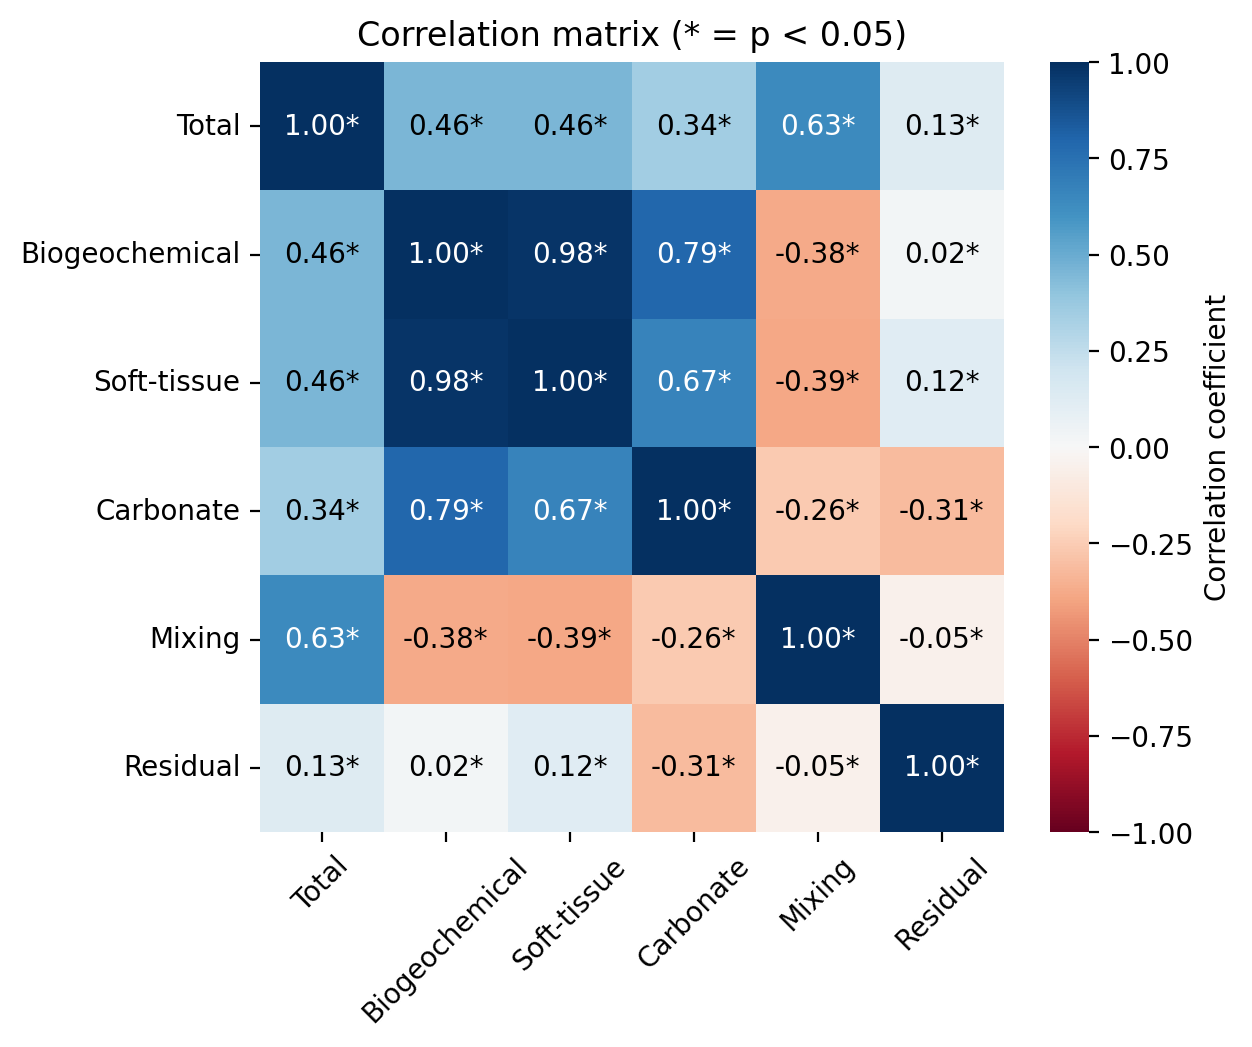

In [46]:
# create a pandas dataframe from the numpy arrays
df_full = pd.DataFrame({
    "Total": ds.DDIC[:, 1:].values.flatten(),
    "Biogeochemical": ds.DDIC_bio[:, 1:].values.flatten(),
    "Soft-tissue": ds.DDIC_bio_soft[:, 1:].values.flatten(),
    "Carbonate": ds.DDIC_bio_carbonate[:, 1:].values.flatten(),
    "Mixing": ds.DDIC_diff[:, 1:].values.flatten(),
    "Residual": ds.DDIC_residual[:, 1:].values.flatten(),
})

plot_correlation_matrix(df_full)

In [47]:
df_relabs_significant_pretty.iloc[:5]

,Biogeochemical,Soft-tissue,Carbonate,Mixing,Residual
All,68.011459,59.189709,14.633503,8.737823,17.438995
Below mixed layer,64.463051,56.623837,15.238794,8.691640,19.445728
Below mixing layer,64.417740,56.586494,15.246141,8.711701,19.455696
Within mixed layer,64.396698,55.271160,13.700869,16.110329,14.917595
Within mixing layer,60.701305,51.343712,12.881107,22.616232,13.158957


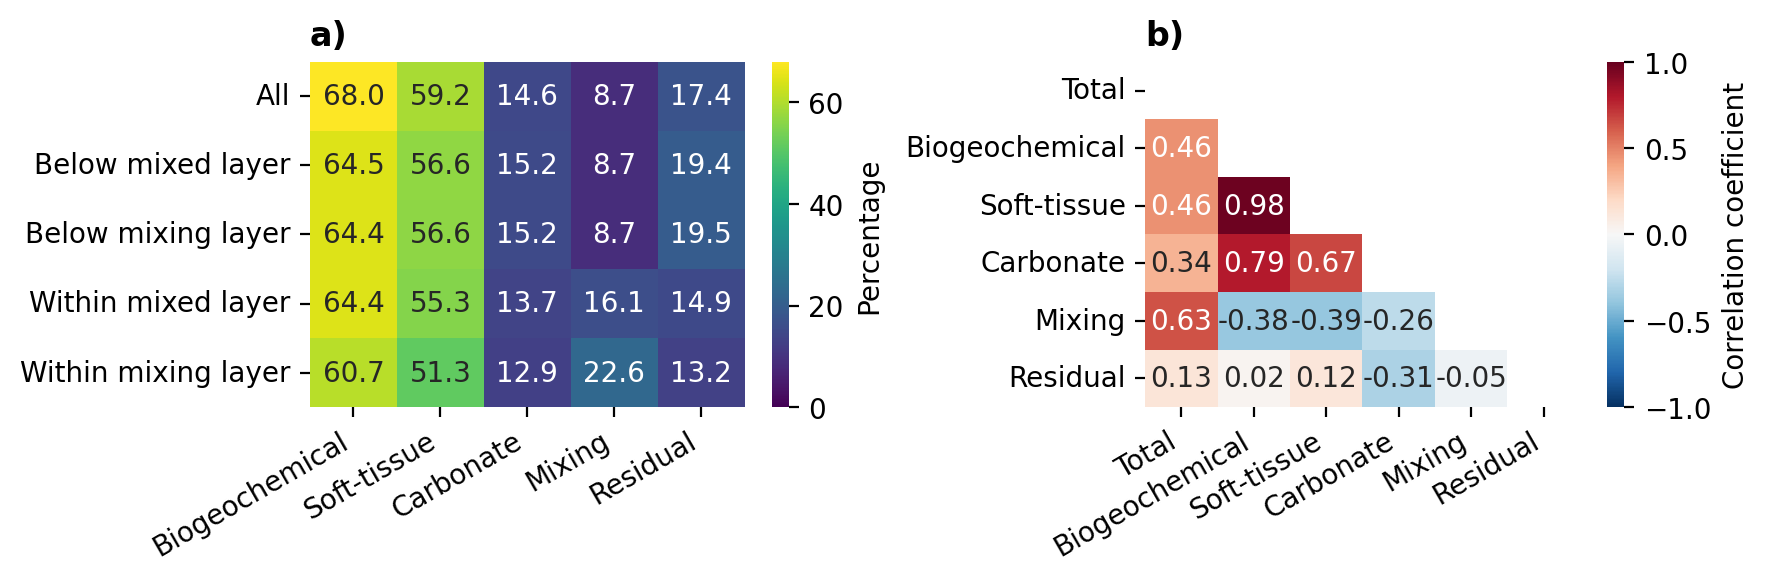

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 3))

sns.heatmap(df_relabs_significant_pretty.iloc[:5], ax=axes[0], annot=True, cmap="viridis", fmt=".1f", cbar_kws={"label": "Percentage"}, vmin=0)
axes[0].set_title("a)", loc="left", fontweight="bold")
axes[0].set_xticks(np.arange(0.5, 5+.5), df_relabs.columns, rotation=30, ha='right')

n_var = len(df_full.columns)

corr = df_full.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, ax=axes[1], mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1, cbar_kws={"label": "Correlation coefficient"})

axes[1].set_title("b)", loc="left", fontweight="bold")
axes[1].set_xticks(np.arange(0.5, n_var+.5), df_full.columns, rotation=30, ha='right')
axes[1].set_yticks(np.arange(0.5, n_var+.5), df_full.columns, rotation=0)

fig.tight_layout()
plt.savefig("figures/flux_significance_and_correlation.pdf", dpi=300)

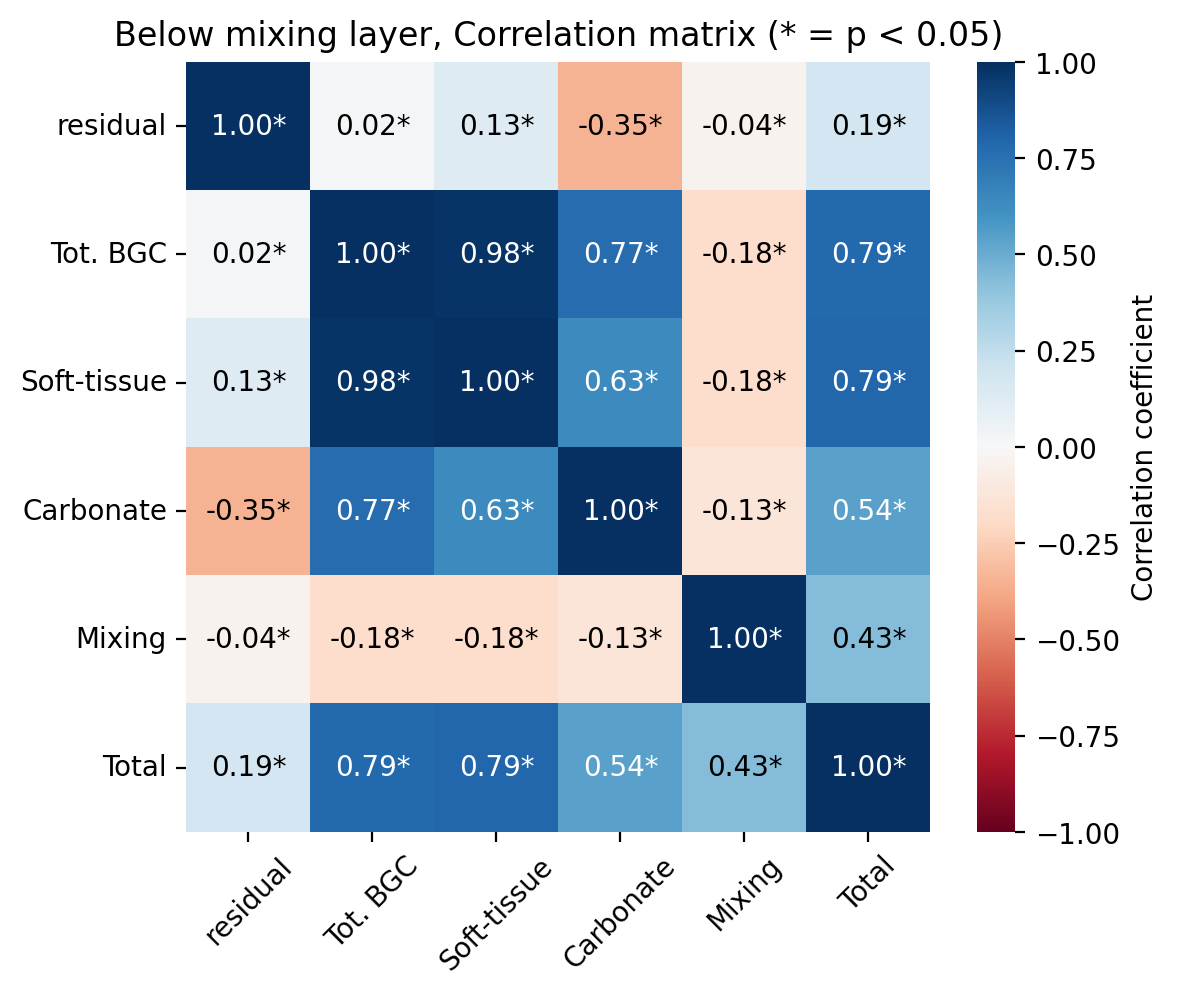

In [69]:
df_below_mixingl = pd.DataFrame({
    "residual": ds.DDIC_residual[:, 1:].values.flatten()[below_mixing.data.flatten()],
    "Tot. BGC": ds.DDIC_bio[:, 1:].values.flatten()[below_mixing.data.flatten()],
    "Soft-tissue": ds.DDIC_bio_soft[:, 1:].values.flatten()[below_mixing.data.flatten()],
    "Carbonate": ds.DDIC_bio_carbonate[:, 1:].values.flatten()[below_mixing.data.flatten()],
    "Mixing": ds.DDIC_diff[:, 1:].values.flatten()[below_mixing.data.flatten()],
    "Total": ds.DDIC[:, 1:].values.flatten()[below_mixing.data.flatten()]
})

plot_correlation_matrix(df_below_mixingl, add_title="Below mixing layer")

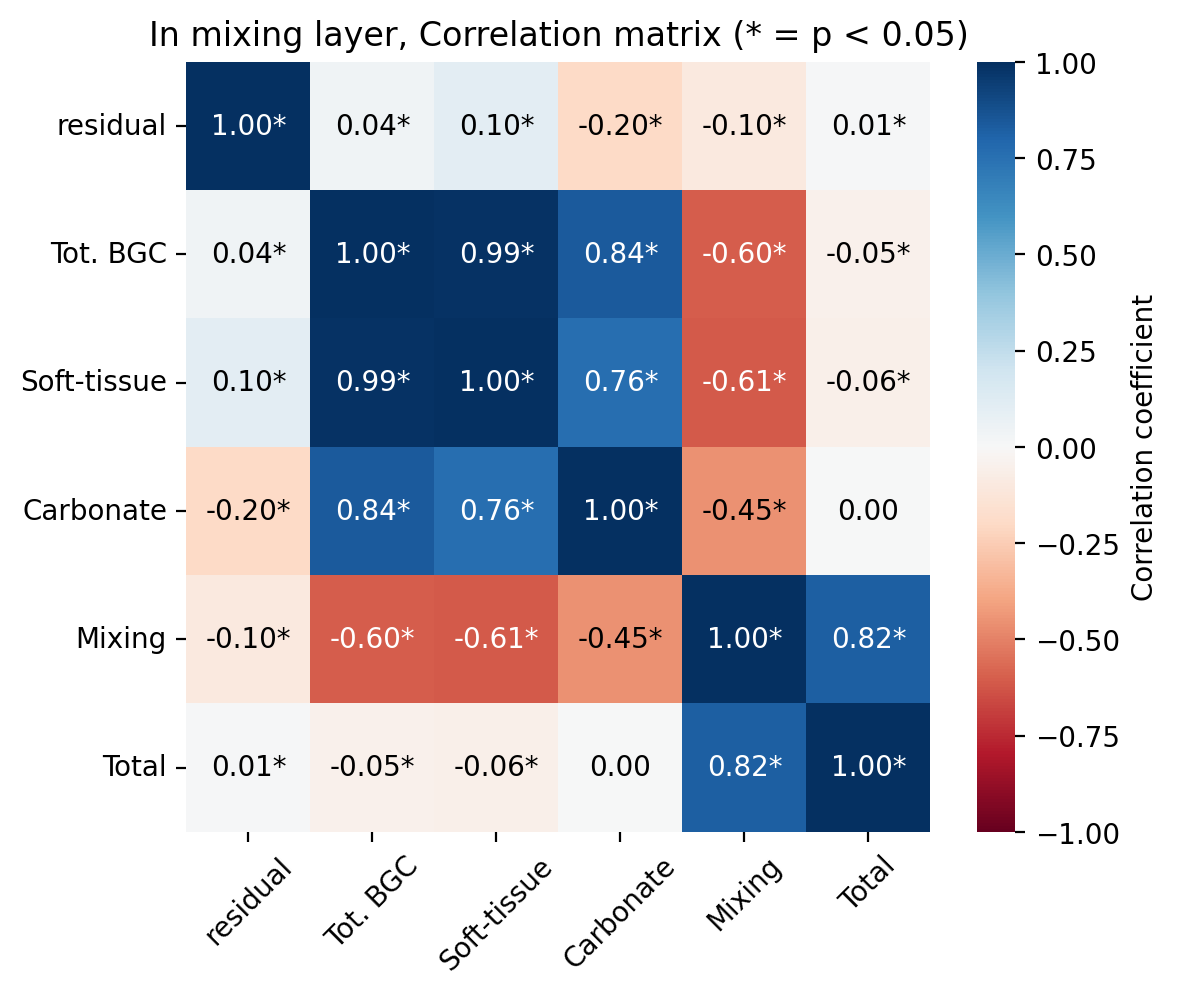

In [70]:
df_in_mixingl = pd.DataFrame({
    "residual": ds.DDIC_residual[:, 1:].values.flatten()[~below_mixing.data.flatten()],
    "Tot. BGC": ds.DDIC_bio[:, 1:].values.flatten()[~below_mixing.data.flatten()],
    "Soft-tissue": ds.DDIC_bio_soft[:, 1:].values.flatten()[~below_mixing.data.flatten()],
    "Carbonate": ds.DDIC_bio_carbonate[:, 1:].values.flatten()[~below_mixing.data.flatten()],
    "Mixing": ds.DDIC_diff[:, 1:].values.flatten()[~below_mixing.data.flatten()],
    "Total": ds.DDIC[:, 1:].values.flatten()[~below_mixing.data.flatten()]
})

plot_correlation_matrix(df_in_mixingl, add_title="In mixing layer")